In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

plt.style.use('default')

# 비지도 학습
예산을 많이 받아먹고 각광받는 것은 지도학습이지만 현실은 데이터에 레이블이 없는 경우가 허다하다.  
이 경우에 모든 샘플에 레이블을 일일이 붙여야 하지만, 바로 이용할 수 있는 방법도 있다.
* 군집 (clustering)  
비슷한 샘플을 클러스터로 모아준다.
* 이상치 탐지 (outlier detection)  
정상 데이터가 어떻게 보이는지를 학습하고 이 데이터와 멀리 떨어진 경우 이상치로 판단한다.  
* 밀도 추정  
데이터셋 생성 확률 과정 (random process)의 확률 밀도 함수를 추정한다.  
이 함수는 이상치 탐지에 사용되고 밀도가 낮은 곳에 위치한 데이터일수록 이상치일 확률이 올라간다


## 군집 (clustering)
레이블을 몰라도 그냥 비슷해보이는 샘플끼리 묶어 주는 것은 가능하다.  
묶어주는 단위를 클러스터라고 부르고 분류와 마찬가지로 각 샘플은 하나의 클러스터에 묶인다.  
<br>
### k-평균
센트로이드라는 기준 점이 되는 데이터 포인트를 랜덤하게 선정한다. (우선 무작위로 k개의 샘플을 뽑는다)  
그 다음 모든 샘플에 가까이 있는 센트로이드의 클러스터를 할당하고, 새롭게 센트로이드를 업데이트 한다.  
이 과정을 반복하면 제한된 횟수 안에 수렴하는 것을 보장한다.  
(계산복잡도는 샘플, 클러스터, 차원 개수에 선형적이다. 단, 군집할 수 없는 데이터 구조라면 폭증한다)  
그런데 센트로이드 초기화를 할 때 잘못하면 최적의 결과에 도달하지 못할 수 있다.  
센트로이드 초기화를 최적화하여 해결할 수 있는데 그냥 랜덤 초기화를 여러 번 시행하여 가장 좋은 솔루션을 얻는다.  
최선의 솔루션을 얻을 수 있는 지표는 가장 가까운 센트로이드 사이의 평균제곱 거리이며 이를 **이너셔(inertia)**라고 부른다.  
사이킷런의 score()메서드는 이너셔의 음숫값을 반환하는데, 큰것이 좋다는 사이킷런의 큐칙을 따라야하기 때문이다.
<br><br>


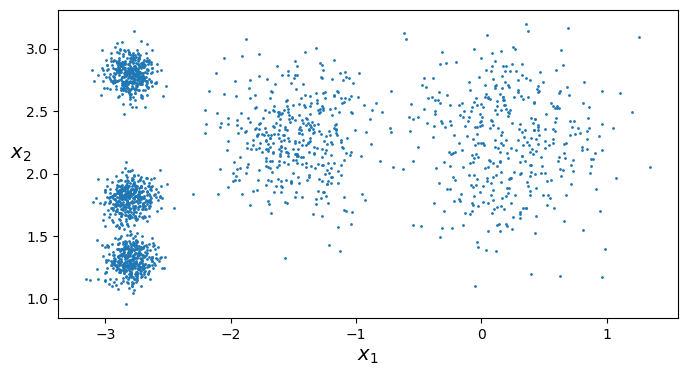

In [2]:
from sklearn.datasets import make_blobs

blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8],
                         [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000,
                  centers=blob_centers,
                  cluster_std=blob_std,
                  random_state=7)


def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)


plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [3]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
print(y_pred)
print(kmeans.labels_) # KMeans 클래스의 인스턴스는 labels_ 인스턴스 변수에 훈련된 샘플의 레이블을 가짐
print(kmeans.cluster_centers_) # 찾은 센트로이드 (k=5)를 저장한다.

[4 1 0 ... 3 0 1]
[4 1 0 ... 3 0 1]
[[ 0.20876306  2.25551336]
 [-2.80389616  1.80117999]
 [-1.46679593  2.28585348]
 [-2.79290307  2.79641063]
 [-2.80037642  1.30082566]]


### k-평균++
k-평균++ 알고리즘이 2006년에 발표되었는데 최적이 아닌 솔루션으로 수렴할 가능성을 크게 낮춰주었다.  
우선 데이터셋에서 무작위로 균등하게 하나의 센트로이드를 선택하고 현재 샘플의 가장 가까운 센트로이드까지의 거리 제곱이 모든 샘플에 대하여 샘플과 가장 가까운 센트로이드와의 거리의 제곱 중에서 차지하는 비율을 확률로 이용하여  
하나의 샘플을 새로운 센트로이드로 선택한다.  
이 확률 분포는 이미 선택한 센트로이드와 멀리 떨어진 샘플을 센트로이드로 선정하게 도와준다.

### k- 평균 속도 개선과 미니배치
불필요한 거리 계산을 많이 피함으로써 알고리즘의 속도를 높일 수 있다.  
이는 삼각 부등식과 샘플과 센트로이드 사이의 거리에 대한 하한과 상한선을 정해줌으로써 구현할 수 있다.  
이 방식은 KMeans에서 기본값으로 이용된다.
<br><br>
또는 데이터를 전체를 한꺼번에 보내주는 것보다 미니배치를 이용하여 센트로이드를 조금씩 이동시킨다.  
이를 이용하면 알고리즘의 속도를 3배에서 4배 정도 높일 수 있으며 메모리에 들어가지 않는 대량의 데이터셋에  
클러스터링 알고리즘을 적용할 수 있다.  
사이킷런에는 MiniBatchKMeans에 구현되어 있으며 KMeans와 같은 방법으로 이용이 가능하다.

In [4]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

C:\Users\hesh0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 5120 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


MiniBatchKMeans(n_clusters=5)

### 최적의 클러스터 개수(k) 찾기
클러스터의 개수가 적으면 별개의 클러스터를 합치고 많을수록 같은 클러스터를 나눠버리게 된다.  
이너셔는 k가 증가할 수록 감소하므로 손실함수처럼 이용하기에는 좋지않다.  
물론 k를 늘려가면서 이너셔의 감소율을 보다가 느리게 감소하기 시작하는 지점인 엘보를 찾으면 되지만 너무 엉성하다.
<br>
더 정확한 방법은 **실루엣 점수**를 구하는 것이다. 이 값은 모든 샘플에 대한 **실루엣 계수**의 평균이다.  
샘플의 실루엣 계수는 다음과 같은 식으로 구해진다.  
\begin{equation}
    (b-a)\; / \max{(a,b)}
\end{equation}
(단, a는 동일한 클러스터에 있는 다른 샘플까지 평균 거리이고 b는 가장 가까운 다른 클러스터까지 평균 거리)  
계수가 1에 가까울수록 자신이 속한 클러스터에 잘 속해있으며 0에 가까울 수록 경계에 위치해있으며  
-1에 가깝다면 샘플이 잘못된 클러스터에 위치해있음을 의미한다.

In [5]:
from sklearn.metrics import silhouette_score
silhouette_score(X,kmeans.labels_)

0.655517642572828

모든 모든 샘플의 실루엣 계수를 클러스터와 계수값으로 정렬한 **실루엣 다이어그램**을 살펴보자.  
높이는 클러스터가 포함한 샘플의 개수를, 너비는 샘플의 실루엣 계수를 나타낸다.  
수직 파선은 클러스터 개수에 해당하는 실루엣 점수를 나타내는데, 이 점수보다 낮은 계수를 가지면  
클러스터의 샘플이 다른 클러스터랑 가깝다는 것을 의미한다.  
k값을 정할 때 모든 샘플이 해당 파선을 넘기고 굵기가 동일한 것을 골라야 한다.

C:\Users\hesh0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


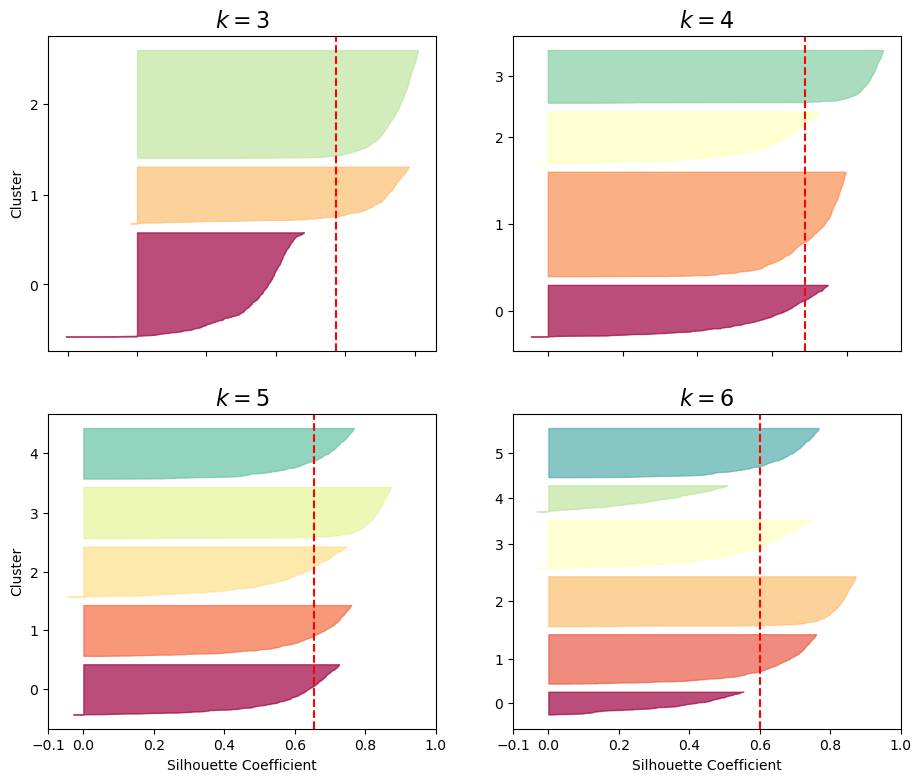

In [6]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)
]
silhouette_scores = [
    silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]
]

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)),
                          0,
                          coeffs,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### k평균의 한계
속도도 빠르고 확장도 용이한 k평균에도 단점은 존재한다.  
1. 최적이 아닌 솔루션을 피하기 위해 알고리즘을 여러 번 실행시켜야 한다.  
2. 클러스터 개수를 직접 지정해야 한다.  
3. 클러스터의 크기나 밀집도가 서로 다르고 원형이 아니라면 잘 작동하지 않는다.

### 군집을 이용한 이미지 분할
말 그대로 이미지를 여러 세그먼트로 나눠버리는 작업이다.  
시맥틱 분할에서는 동일한 종류의 물체에 속한 모든 픽셀을 같은 세그먼트에 할당시킨다.  
좋은 성능을 내기 위해서는 CNN을 사용해야 하지만 우선 색상 분할로 진행해보자.  
이 알고리즘에서는 동일한 색상을 가진 픽셀을 같은 세그먼트에 할당시킨다.  

In [7]:
import urllib.request

PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

from matplotlib.image import imread

image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

각 픽셀에 대한 RGB값(0~1)이 담긴 3D 벡터에 대하여 RGB색상의 리스트로 변환한다.  
그 다음 이를 KMeans를 이용하여 색상을 클러스터로 모아준다.

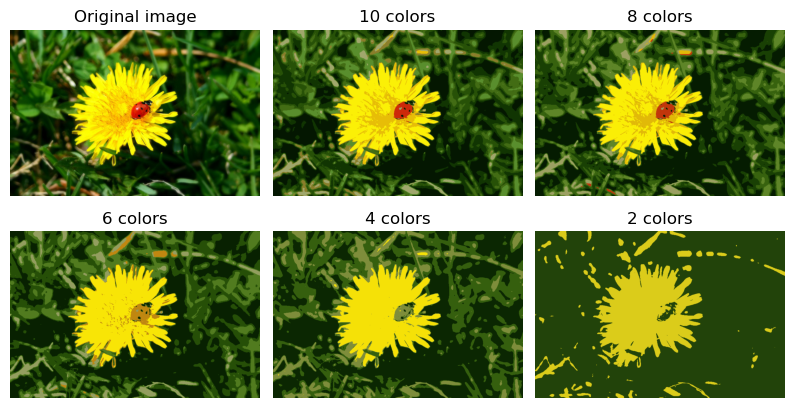

In [8]:
X = image.reshape(-1,3)
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

비슷한 색들을 하나의 클러스터로 묶어줄 수 있지만 묶을 수 있는 색의 개수가 줄어듬에 따라 주위 색에 합쳐진다.  
이는 KMeans가 비슷한 크기의 클러스터를 만들려는 경향이 있기 때문이다.

### 군집을 사용한 전처리
군집은 지도 학습을 적용하기 전에 전처리 단계에 이용될 수 있다. 예를 들어 차원 축소에 군집을 사용할 수 있다.

In [9]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits,
                                                    y_digits,
                                                    random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9688888888888889

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("kmeans", KMeans(n_clusters=50)),
                     ("log_reg",
                      LogisticRegression(multi_class="ovr",
                                         solver="lbfgs",
                                         max_iter=5000,
                                         random_state=42))])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9777777777777777

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train,y_train)
grid_clf.best_params_

{'kmeans__n_clusters': 92}

In [13]:
print(grid_clf.score(X_test,y_test))

0.98


### 군집을 사용한 준지도 학습
레이블이 없는 데이터가 많고 레이블이 있는 데이터가 적을 때 이용 가능한 방법인 준지도 학습.  
훈련 세트를 k개의 클러스터로 모으고 각 클러스터에서 센트로이드에 가장 가까운 대표 이미지를 찾는다.  
대표 이미지만으로 구성된 적은 수의 샘플들이더라도 정확도가 비약적으로 상승하게 된다.

In [20]:
n_labeled = 50
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train[:n_labeled],y_train[:n_labeled])
log_reg.score(X_test,y_test)

0.8222222222222222

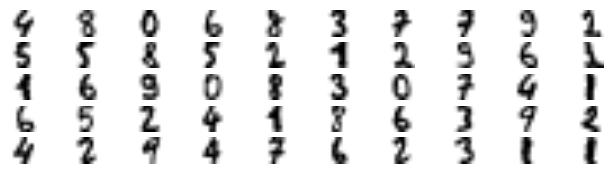

In [28]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)

# 각 클러스터마다 센트로이드에 가장 가까운 대표 이미지를 찾는다.
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [39]:
y_representative_digits = y_train[representative_digit_idx]
print(y_representative_digits.shape)

(50,)


In [37]:
log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)
# 단 50개의 이미지로 정확도 92퍼를 달성했다
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

그런데 여기서 더 나아가 대표 이미지의 레이블을 해당 클러스터에 속한 모든 샘플에 전파하면 어떨까?  
이를 **레이블 전파 (label propagation)** 이라고 부른다.

In [77]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

성능이 좋아지긴 했지만, 경계에 있는 레이블들의 경우 에러가 발생했을 확률이 높다.  
이번에는 센트로이드와 가까운 샘플의 15%에만 레이블을 전파해보자.

In [63]:
percentile_closest = 15

# 각 샘플마다 속한 클러스터에서의 센트로이드 까지의 거리가 담긴다.
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

# 클러스터안에 속해있지만 15% 밖에 있는 샘플의 거리를 -1로 설정한다.
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

# 거리가 -1을 제외한 모든 샘플에 레이블 전파를 적용한다.
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(multi_class="ovr",
                             solver="lbfgs",
                             max_iter=5000,
                             random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.score(X_test, y_test)

0.9466666666666667

성능이 좋아짐을 알 수 있는데 이는 실제로 부분 전파된 샘플과 실제 데이터가 거의 일치하기 때문이다.

In [52]:
np.mean(y_train_partially_propagated==y_train[partially_propagated])

0.9908675799086758